In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib.resources
import fitsio
import astropy.table
import scipy.interpolate as interpolate
import scipy.integrate as integrate

import fgcm
import lsst.utils

In [2]:
template_file = importlib.resources.path("fgcm.data.templates", "stellar_templates_master.fits")

In [3]:
fits = fitsio.FITS(template_file)
fits.update_hdu_list()
ext_names = []
for hdu in fits.hdu_list:
    ext_name = hdu.get_extname()
    if ('TEMPLATE_' in ext_name):
        ext_names.append(ext_name)

n_templates = len(ext_names)

templates = {}
for i in range(n_templates):
    templates[i] = fits[ext_names[i]].read(lower=True)
fits.close()

In [4]:
filters = ["u", "g", "r", "i", "z", "y"]
throughputs = {}
for filter_ in filters:
    tput = astropy.table.Table.read(f"https://raw.githubusercontent.com/lsst/throughputs/main/baseline/total_{filter_}.dat", format="ascii")
    tput.rename_column("col1", "wavelength")
    tput.rename_column("col2", "throughput")
    throughputs[filter_] = tput


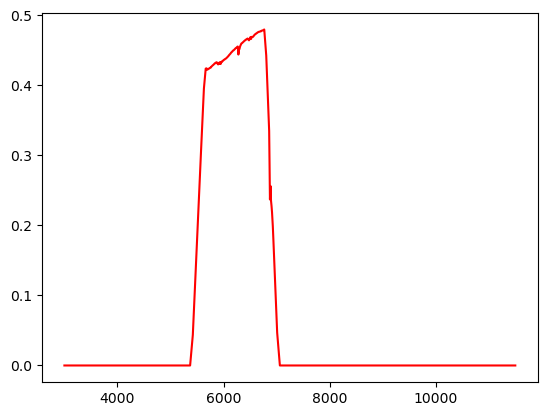

In [5]:
plt.plot(throughputs["r"]["wavelength"]*10, throughputs["r"]["throughput"], 'r-')

In [6]:
lsst_mags = np.zeros((len(filters), n_templates))

In [7]:
for i in range(n_templates):
    for j, filter_ in enumerate(filters):
        template_lambda = templates[i]['lambda']
        template_f_lambda = templates[i]['flux']
        template_f_nu = template_f_lambda * template_lambda * template_lambda
        
        int_func = interpolate.interp1d(template_lambda, template_f_nu)
        tput_lambda = throughputs[filter_]["wavelength"]*10.
        f_nu = np.zeros(tput_lambda.size)
        # Make sure we interpolate in range
        good, = np.where((tput_lambda >= template_lambda[0]) & (tput_lambda <= template_lambda[-1]))
        f_nu[good] = int_func(tput_lambda[good])
        # out of range, let it hit the limit
        lo, = np.where(tput_lambda < template_lambda[0])
        f_nu[lo] = int_func(tput_lambda[good[0]])
        hi, = np.where(tput_lambda > template_lambda[-1])
        f_nu[hi] = int_func(tput_lambda[good[-1]])

        num = integrate.simpson(f_nu*throughputs[filter_]["throughput"]/tput_lambda, tput_lambda)
        denom = integrate.simpson(throughputs[filter_]["throughput"]/tput_lambda, tput_lambda)
        
        lsst_mags[j, i] = -2.5*np.log10(num/denom)

Text(0.5, 0, 'r - i (lsst)')

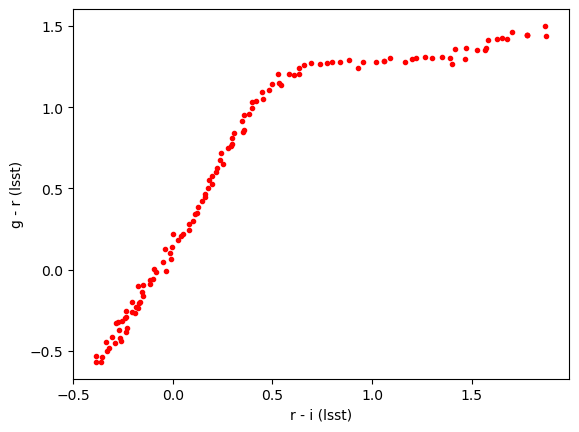

In [8]:
plt.plot(lsst_mags[2, :] - lsst_mags[3, :], lsst_mags[1, :] - lsst_mags[2, :], 'r.')
plt.ylabel("g - r (lsst)")
plt.xlabel("r - i (lsst)")

Text(0.5, 0, 'i - z (lsst)')

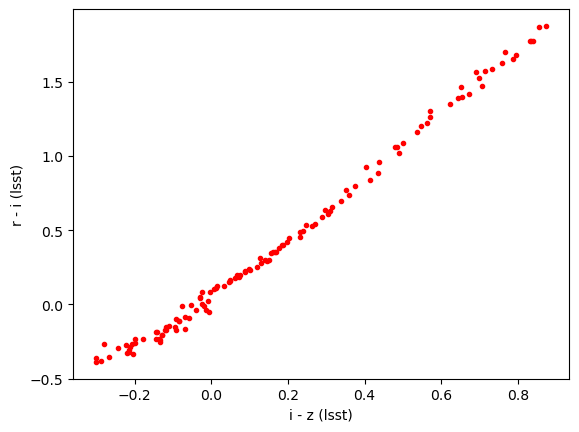

In [9]:
plt.plot(lsst_mags[3, :] - lsst_mags[4, :], lsst_mags[2, :] - lsst_mags[3, :], 'r.')
plt.ylabel("r - i (lsst)")
plt.xlabel("i - z (lsst)")

Text(0.5, 0, 'z - y (lsst)')

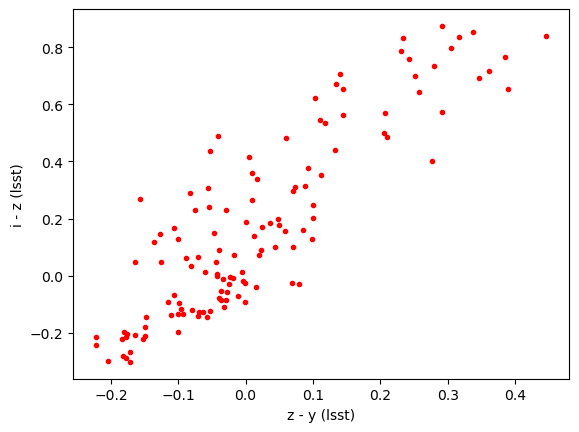

In [10]:
plt.plot(lsst_mags[4, :] - lsst_mags[5, :], lsst_mags[3, :] - lsst_mags[4, :], 'r.')
plt.ylabel("i - z (lsst)")
plt.xlabel("z - y (lsst)")

Text(0.5, 0, 'g - r (lsst)')

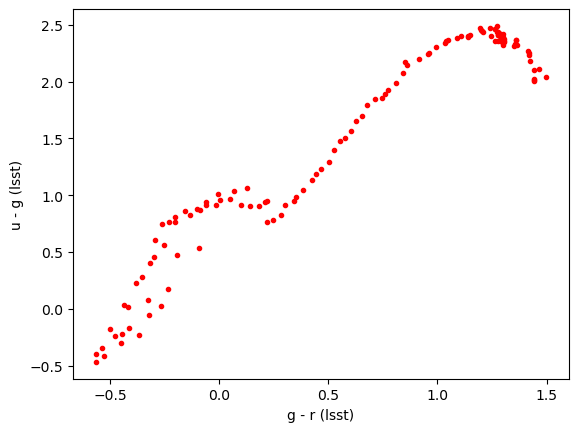

In [11]:
plt.plot(lsst_mags[1, :] - lsst_mags[2, :], lsst_mags[0, :] - lsst_mags[1, :], 'r.')
plt.ylabel("u - g (lsst)")
plt.xlabel("g - r (lsst)")

In [12]:
des_passbands = astropy.table.Table.read("https://noirlab.edu/science/sites/default/files/media/archives/documents/scidoc1884.txt", format="fits")
print(des_passbands)

 LAMBDA           g             r   i   z   Y     atm    
------- ---------------------- --- --- --- --- ----------
 3800.0                    0.0 0.0 0.0 0.0 0.0    0.60928
 3805.0 0.00023971615883056074 0.0 0.0 0.0 0.0   0.610776
 3810.0  0.0004806068609468639 0.0 0.0 0.0 0.0  0.6122723
 3815.0  0.0005389155703596771 0.0 0.0 0.0 0.0  0.6137075
 3820.0  0.0005975518142804503 0.0 0.0 0.0 0.0  0.6152045
 3825.0  0.0006007966003380716 0.0 0.0 0.0 0.0 0.61661017
 3830.0  0.0006040793377906084 0.0 0.0 0.0 0.0   0.618046
 3835.0  0.0006971394177526236 0.0 0.0 0.0 0.0  0.6193279
 3840.0  0.0007906169048510492 0.0 0.0 0.0 0.0 0.62063926
 3845.0  0.0008705612272024155 0.0 0.0 0.0 0.0  0.6219832
    ...                    ... ... ... ... ...        ...
10950.0                    0.0 0.0 0.0 0.0 0.0 0.94203603
10955.0                    0.0 0.0 0.0 0.0 0.0  0.9410873
10960.0                    0.0 0.0 0.0 0.0 0.0 0.93687814
10965.0                    0.0 0.0 0.0 0.0 0.0  0.9433195
10970.0       

In [13]:
des_filters = ["g", "r", "i", "z", "Y"]
des_mags = np.zeros((len(des_filters), n_templates))
for i in range(n_templates):
    for j, filter_ in enumerate(des_filters):
        template_lambda = templates[i]['lambda']
        template_f_lambda = templates[i]['flux']
        template_f_nu = template_f_lambda * template_lambda * template_lambda
        
        int_func = interpolate.interp1d(template_lambda, template_f_nu)
        tput_lambda = des_passbands["LAMBDA"]
        f_nu = np.zeros(tput_lambda.size)
        # Make sure we interpolate in range
        good, = np.where((tput_lambda >= template_lambda[0]) & (tput_lambda <= template_lambda[-1]))
        f_nu[good] = int_func(tput_lambda[good])
        # out of range, let it hit the limit
        lo, = np.where(tput_lambda < template_lambda[0])
        f_nu[lo] = int_func(tput_lambda[good[0]])
        hi, = np.where(tput_lambda > template_lambda[-1])
        f_nu[hi] = int_func(tput_lambda[good[-1]])

        num = integrate.simpson(f_nu*des_passbands[filter_]/tput_lambda, tput_lambda)
        denom = integrate.simpson(des_passbands[filter_], tput_lambda)
        
        des_mags[j, i] = -2.5*np.log10(num/denom)


In [14]:
des_rmi = des_mags[1, :] - des_mags[2, :]
des_gmi = des_mags[0, :] - des_mags[2, :]
des_imz = des_mags[2, :] - des_mags[3, :]

Text(0, 0.5, 'lsst_g - des_g')

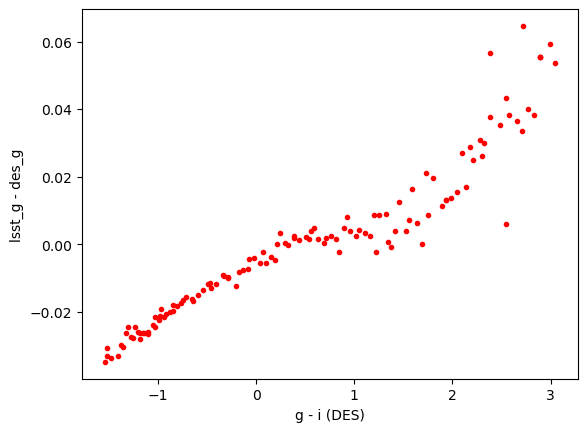

In [15]:
plt.plot(des_gmi, lsst_mags[1, :] - des_mags[0, :] - np.median(lsst_mags[1, :] - des_mags[0, :]), 'r.')
plt.xlabel('g - i (DES)')
plt.ylabel('lsst_g - des_g')

Text(0, 0.5, 'lsst_r - des_r')

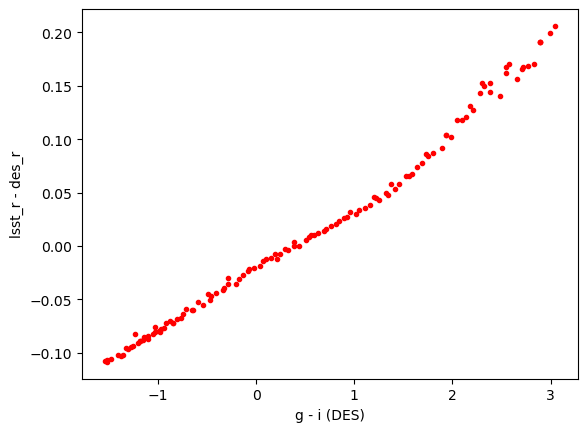

In [16]:
plt.plot(des_gmi, lsst_mags[2, :] - des_mags[1, :] - np.median(lsst_mags[2, :] - des_mags[1, :]), 'r.')
plt.xlabel('g - i (DES)')
plt.ylabel('lsst_r - des_r')

Text(0, 0.5, 'lsst_i - des_i')

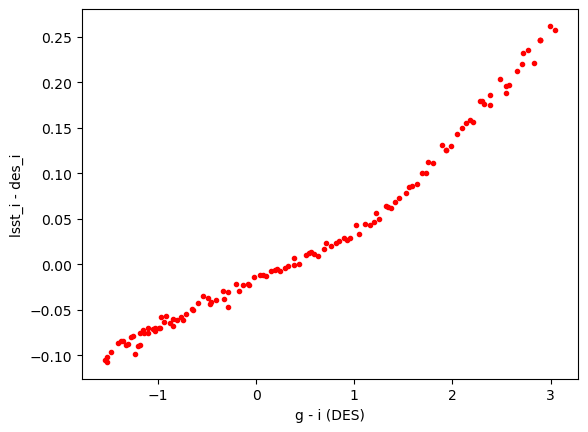

In [17]:
plt.plot(des_gmi, lsst_mags[3, :] - des_mags[2, :] - np.median(lsst_mags[3, :] - des_mags[2, :]), 'r.')
plt.xlabel('g - i (DES)')
plt.ylabel('lsst_i - des_i')

Text(0, 0.5, 'lsst_i - des_i')

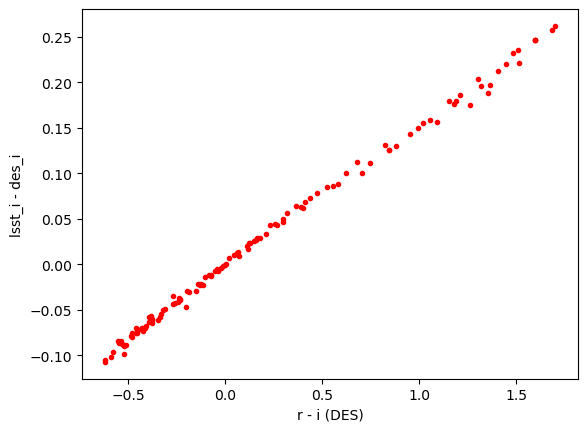

In [18]:
plt.plot(des_rmi, lsst_mags[3, :] - des_mags[2, :] - np.median(lsst_mags[3, :] - des_mags[2, :]), 'r.')
plt.xlabel('r - i (DES)')
plt.ylabel('lsst_i - des_i')

Text(0, 0.5, 'lsst_z - des_z')

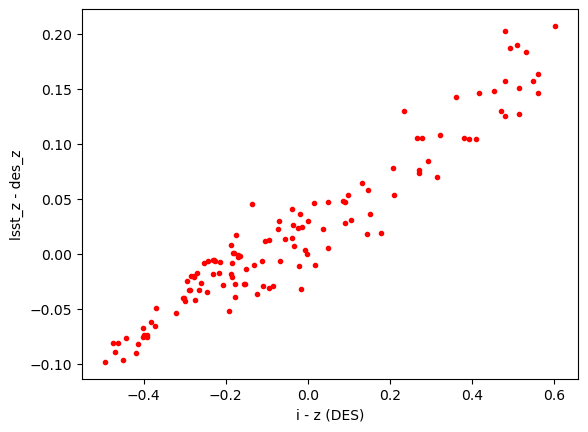

In [19]:
plt.plot(des_imz, lsst_mags[4, :] - des_mags[3, :] - np.median(lsst_mags[4, :] - des_mags[3, :]), 'r.')
plt.xlabel('i - z (DES)')
plt.ylabel('lsst_z - des_z')

Text(0, 0.5, 'lsst_y - des_Y')

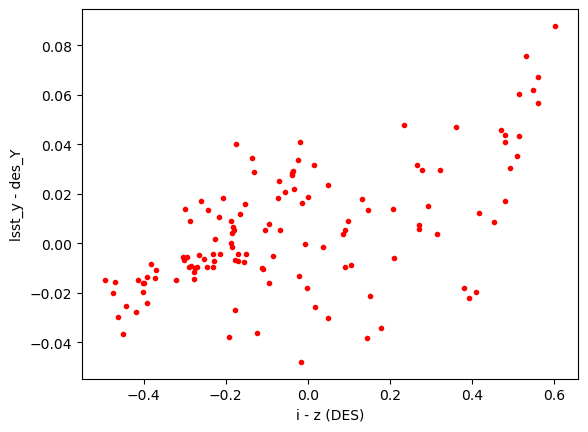

In [20]:
plt.plot(des_imz, lsst_mags[5, :] - des_mags[4, :] - np.median(lsst_mags[5, :] - des_mags[4, :]), 'r.')
plt.xlabel('i - z (DES)')
plt.ylabel('lsst_y - des_Y')